# Hands on : Introduction to BDT on HEP dataset

1. Load data from root (make sure packages load!)
2. Explore the data and weights
3. Preprocess data for training
4. Train a Boosted Decision Tree
5. Quantify its performance

This tutorial will probably be a bit more hands-on, focusing a bit more on the data and preprocessing. The Neural Network tutorial later today will give more time to play around with training. Feel free to revisit this notebook later today! 

### Many thanks to _David Rousseau, Yann Coadou_, and _Aishik Gosh_. This tutorial is based on their work!

## Import Packages

In [1]:
import os
import numpy as np
import pandas as pd
import uproot as ur

import matplotlib.pyplot as plt
from IPython.display import display, HTML

%matplotlib inline
import time

pd.set_option('display.max_columns', 100)  # to see more columns of df.head()
np.random.seed(31415)  # set the np random seed for the reproducibility

# some utilities
from math import sqrt
from math import log

In [2]:
# import xgboost

#print(xgboost.__version__)  # Tested with 1.6.1, version above 1 is recommended.
import lightgbm

print(lightgbm.__version__)  # Tested with 2.2.3
import sklearn

print(sklearn.__version__)  # Tested with 1.0.2

3.3.5
1.2.2


# Load events

[created from [ATLAS Open Data](http://opendata.atlas.cern/release/2020/documentation/datasets/intro.html)]

In [3]:
filename = "dataWW_d1.root"
file = ur.open(filename)
print(file.classnames())

{'tree_event;1': 'TTree'}


In [4]:
tree = file["tree_event"]
dfall = tree.arrays(library="pd")
print("File loaded with ", dfall.shape[0], " events ")

File loaded with  600000  events 


In [5]:
# shuffle the events, already done but just to be safe!
dfall = dfall.sample(frac=1).reset_index(drop=True)
from datetime import datetime

print("now :", datetime.now())
print("File loaded with ", dfall.shape[0], " events ")

now : 2023-08-30 16:39:52.510844
File loaded with  600000  events 


At this point, it should tell you "File Loaded with XXX events". If not, it could not access the datafile. No point going further!

# Examine dataset

In [6]:
# dump list of features
dfall.columns

Index(['index', 'eventNumber', 'label', 'met_et', 'met_phi', 'lep_n',
       'lep_pt_0', 'lep_pt_1', 'lep_eta_0', 'lep_eta_1', 'lep_phi_0',
       'lep_phi_1', 'lep_E_0', 'lep_E_1', 'lep_charge_0', 'lep_charge_1',
       'lep_type_0', 'lep_type_1', 'jet_n', 'jet_pt_0', 'jet_pt_1',
       'jet_eta_0', 'jet_eta_1', 'jet_phi_0', 'jet_phi_1', 'jet_E_0',
       'jet_E_1', 'mcWeight', 'runNumber', 'channelNumber'],
      dtype='object')

In [7]:
dfall.mcWeight *= 4  # arbitrary scale to have larger significance

In [8]:
# examine first few events
display(dfall.head())
display(dfall.head())

,index,eventNumber,label,met_et,met_phi,lep_n,lep_pt_0,lep_pt_1,lep_eta_0,lep_eta_1,lep_phi_0,lep_phi_1,lep_E_0,lep_E_1,lep_charge_0,lep_charge_1,lep_type_0,lep_type_1,jet_n,jet_pt_0,jet_pt_1,jet_eta_0,jet_eta_1,jet_phi_0,jet_phi_1,jet_E_0,jet_E_1,mcWeight,runNumber,channelNumber
0,543448,402756,1,25.609,0.42452,2,48.295,15.214,0.73991,2.27420,-2.316400,-1.39410,62129.0,74721.0,-1,1,13,11,2,26.32,20.064,-1.1350,-2.07540,-2.8092,2.0740,45397.0,81304.0,0.000008,284500,345323
1,580260,101274,0,196.560,1.31140,2,69.459,21.081,-0.52666,0.22380,0.023132,-0.67855,79317.0,21611.0,-1,1,13,13,2,192.12,36.217,-1.2643,-0.69746,-2.2147,-1.9152,367670.0,45733.0,0.001153,284500,363492
2,112856,468437,1,45.653,-2.76860,2,45.927,22.822,-1.61910,-2.00770,1.901700,-0.11248,120480.0,86498.0,-1,1,11,11,0,-7.00,-7.000,-7.0000,-7.00000,-7.0000,-7.0000,-7.0,-7.0,0.000116,284500,345324
3,121430,272337,1,49.415,-0.57805,2,45.929,14.263,1.55280,0.12809,2.254700,-2.54810,113360.0,14380.0,-1,1,13,13,0,-7.00,-7.000,-7.0000,-7.00000,-7.0000,-7.0000,-7.0,-7.0,0.000116,284500,345324
4,55912,354546,1,71.988,-2.60390,2,62.029,21.453,-0.51082,-0.38177,0.236200,1.40820,70300.0,23036.0,-1,1,11,13,0,-7.00,-7.000,-7.0000,-7.00000,-7.0000,-7.0000,-7.0,-7.0,0.000008,284500,345323


,index,eventNumber,label,met_et,met_phi,lep_n,lep_pt_0,lep_pt_1,lep_eta_0,lep_eta_1,lep_phi_0,lep_phi_1,lep_E_0,lep_E_1,lep_charge_0,lep_charge_1,lep_type_0,lep_type_1,jet_n,jet_pt_0,jet_pt_1,jet_eta_0,jet_eta_1,jet_phi_0,jet_phi_1,jet_E_0,jet_E_1,mcWeight,runNumber,channelNumber
0,543448,402756,1,25.609,0.42452,2,48.295,15.214,0.73991,2.27420,-2.316400,-1.39410,62129.0,74721.0,-1,1,13,11,2,26.32,20.064,-1.1350,-2.07540,-2.8092,2.0740,45397.0,81304.0,0.000008,284500,345323
1,580260,101274,0,196.560,1.31140,2,69.459,21.081,-0.52666,0.22380,0.023132,-0.67855,79317.0,21611.0,-1,1,13,13,2,192.12,36.217,-1.2643,-0.69746,-2.2147,-1.9152,367670.0,45733.0,0.001153,284500,363492
2,112856,468437,1,45.653,-2.76860,2,45.927,22.822,-1.61910,-2.00770,1.901700,-0.11248,120480.0,86498.0,-1,1,11,11,0,-7.00,-7.000,-7.0000,-7.00000,-7.0000,-7.0000,-7.0,-7.0,0.000116,284500,345324
3,121430,272337,1,49.415,-0.57805,2,45.929,14.263,1.55280,0.12809,2.254700,-2.54810,113360.0,14380.0,-1,1,13,13,0,-7.00,-7.000,-7.0000,-7.00000,-7.0000,-7.0000,-7.0,-7.0,0.000116,284500,345324
4,55912,354546,1,71.988,-2.60390,2,62.029,21.453,-0.51082,-0.38177,0.236200,1.40820,70300.0,23036.0,-1,1,11,13,0,-7.00,-7.000,-7.0000,-7.00000,-7.0000,-7.0000,-7.0,-7.0,0.000008,284500,345323


In [9]:
# examine feature distribution
dfall.describe()

,index,eventNumber,label,met_et,met_phi,lep_n,lep_pt_0,lep_pt_1,lep_eta_0,lep_eta_1,lep_phi_0,lep_phi_1,lep_E_0,lep_E_1,lep_charge_0,lep_charge_1,lep_type_0,lep_type_1,jet_n,jet_pt_0,jet_pt_1,jet_eta_0,jet_eta_1,jet_phi_0,jet_phi_1,jet_E_0,jet_E_1,mcWeight,runNumber,channelNumber
count,600000.000000,6.000000e+05,600000.000000,600000.000000,600000.000000,600000.000000,600000.000000,600000.000000,600000.000000,600000.000000,600000.000000,600000.000000,6.000000e+05,6.000000e+05,600000.000000,600000.000000,600000.000000,600000.000000,600000.000000,600000.000000,600000.000000,600000.000000,600000.000000,600000.000000,600000.000000,6.000000e+05,6.000000e+05,600000.000000,600000.0,600000.000000
mean,299999.500000,7.029775e+05,0.666667,60.365356,-0.008556,2.005748,60.270328,28.133970,0.000269,-0.000664,0.005219,0.008524,1.164008e+05,5.630948e+04,-0.027027,0.027037,11.907273,11.958010,1.334185,59.606114,13.521164,-1.934521,-4.402337,-1.939645,-4.401941,1.375410e+05,4.125468e+04,0.000872,284500.0,351379.666667
std,173205.225094,4.568961e+05,0.471405,48.153210,1.812778,0.076061,42.676858,20.352272,1.210614,1.235890,1.811177,1.814205,1.083341e+05,5.748834e+04,0.999636,0.999635,0.995692,0.999119,1.232632,79.586143,38.074439,3.349404,3.491304,3.489197,3.559421,1.980717e+05,8.990068e+04,0.002944,0.0,8564.720183
min,0.000000,1.000000e+00,0.000000,0.044211,-3.141600,2.000000,25.000000,7.000300,-2.700000,-2.699900,-3.141600,-3.141600,2.501300e+04,7.003800e+03,-1.000000,-1.000000,11.000000,11.000000,0.000000,-7.000000,-7.000000,-7.000000,-7.000000,-7.000000,-7.000000,-7.000000e+00,-7.000000e+00,-0.182228,284500.0,345323.000000
25%,149999.750000,3.498568e+05,0.000000,33.196000,-1.577600,2.000000,36.624750,15.316000,-0.899650,-0.946043,-1.560200,-1.562900,5.221675e+04,2.329100e+04,-1.000000,-1.000000,11.000000,11.000000,0.000000,-7.000000,-7.000000,-7.000000,-7.000000,-7.000000,-7.000000,-7.000000e+00,-7.000000e+00,0.000008,284500.0,345323.000000
50%,299999.500000,6.678815e+05,1.000000,50.082000,-0.018694,2.000000,48.229500,23.644000,0.003413,0.002974,0.014583,0.018823,8.184450e+04,3.824900e+04,-1.000000,1.000000,11.000000,11.000000,1.000000,38.744000,-7.000000,-0.891010,-7.000000,-1.210600,-7.000000,7.501700e+04,-7.000000e+00,0.000116,284500.0,345324.000000
75%,449999.250000,1.001273e+06,1.000000,73.032250,1.559300,2.000000,68.979000,34.149000,0.901950,0.942210,1.573000,1.577300,1.412400e+05,6.730825e+04,1.000000,1.000000,13.000000,13.000000,2.000000,84.291250,26.881000,0.724705,-0.821005,0.967753,-1.088575,1.766200e+05,5.060500e+04,0.000786,284500.0,363492.000000
max,599999.000000,1.997995e+06,1.000000,7062.200000,3.141600,5.000000,7041.400000,744.900000,2.699800,2.700000,3.141500,3.141600,7.041600e+06,2.107900e+06,1.000000,1.000000,13.000000,13.000000,13.000000,1658.200000,1429.800000,2.500000,2.500000,3.141600,3.141600,5.638800e+06,2.784300e+06,0.209680,284500.0,363492.000000


In [10]:
label_weights = (dfall[dfall.label == 0].mcWeight.sum(), dfall[dfall.label == 1].mcWeight.sum())
print("sum of label weights  Background, Signal =", label_weights)

label_nevents = (dfall[dfall.label == 0].shape[0], dfall[dfall.label == 1].shape[0])
print("total class number of events B S", label_nevents)

sum of label weights  Background, Signal = (498.6491778568, 24.8002135904)
total class number of events B S (200000, 400000)


## Event selection

This notebook essentially tries to classify events containing a Higgs Boson.

The simulation includes top-quark-pair production, single-top production, production of weak bosons in association with jets (W+jets, Z+jets), production of a pair of bosons (diboson WW, WZ, ZZ) and __SM Higgs__ production.

We will only keep events with exactly two leptons __dfall.lep_n==2__

In [11]:
print("Df shape before selection :", dfall.shape)

# Also only keep events with positive weight. This is in principle wrong.
# Many Data Science tools break given a negative weight.
fulldata = dfall[(dfall.lep_n == 2) & (dfall.mcWeight > 0)]


print("Df shape after selection :", fulldata.shape)

Df shape before selection : (600000, 30)
Df shape after selection : (577357, 30)


___


### Try not to change the cells above $\uparrow$
...and return to this cell (or rerun the whole notebook) after changing things below.

___

# Explore the Data

### Choose features to train on

In [12]:
# WARNING : there should be no selection nor shuffling later on ! (otherwise misalignement)
target = fulldata["label"]
weights = fulldata["mcWeight"]


# for simplicity of the exercise only keep some features
data = pd.DataFrame(fulldata, columns=["met_et", "met_phi", "lep_pt_0", "lep_pt_1", 'lep_phi_0', 'lep_phi_1'])

print("Df shape of dataset to be used :", data.shape)
display(data.head())
display(target.head())
display(weights.head())

Df shape of dataset to be used : (577357, 6)


,met_et,met_phi,lep_pt_0,lep_pt_1,lep_phi_0,lep_phi_1
0,25.609,0.42452,48.295,15.214,-2.316400,-1.39410
1,196.560,1.31140,69.459,21.081,0.023132,-0.67855
2,45.653,-2.76860,45.927,22.822,1.901700,-0.11248
3,49.415,-0.57805,45.929,14.263,2.254700,-2.54810
4,71.988,-2.60390,62.029,21.453,0.236200,1.40820


0    1
1    0
2    1
3    1
4    1
Name: label, dtype: int64

0    0.000008
1    0.001153
2    0.000116
3    0.000116
4    0.000008
Name: mcWeight, dtype: float64

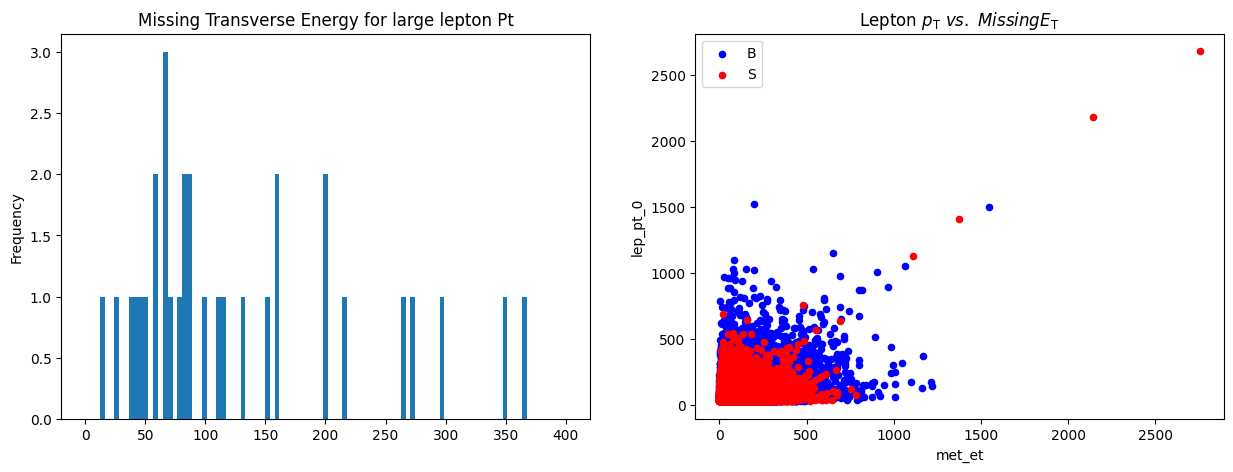

<Figure size 640x480 with 0 Axes>

In [13]:
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# Simple Histo of ET for pT sum > 1000
data[data.lep_pt_0 + data.lep_pt_1 > 1000]['met_et'].plot.hist(
    bins=np.linspace(0, 400, 100), ax=axes[0], title='Missing Transverse Energy for large lepton Pt'
)


# Scatter of pT vs. ET
fig = plt.figure()
data[target == 0].plot.scatter(x='met_et', y='lep_pt_0', color="b", label="B", ax=axes[1])
data[target == 1].plot.scatter(x='met_et', y='lep_pt_0', color="r", label="S", ax=axes[1])
axes[1].set_title("Lepton $p_\mathrm{T}\ vs.\ Missing E_\mathrm{T}$")
plt.show()

In [14]:
# Simple example of pandas array "slicing"
data[data.lep_pt_0 + data.lep_pt_1 > 2000].head()

,met_et,met_phi,lep_pt_0,lep_pt_1,lep_phi_0,lep_phi_1
308053,2755.4,1.8538,2678.7,42.131,-1.2958,0.13151
552671,2145.7,0.3056,2180.0,30.531,-2.8257,1.50800


## Examine the weights

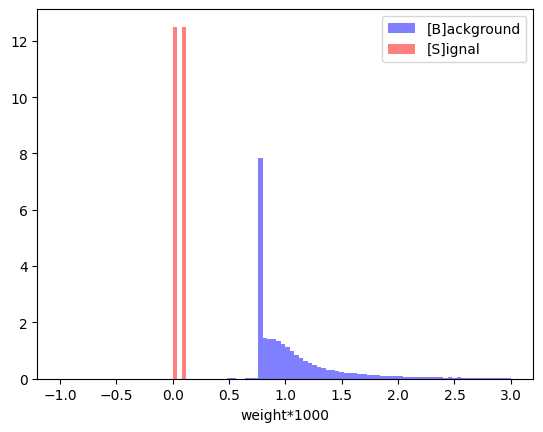

In [15]:
fig, ax = plt.subplots()
# fig=plt.figure()

bins = np.linspace(-1, 3, 101)
plt.hist(weights[target == 0] * 1000, bins=bins, color='b', alpha=0.5, density=True, label='[B]ackground')
plt.hist(weights[target == 1] * 1000, bins=bins, color='r', alpha=0.5, density=True, label='[S]ignal')
plt.legend(loc='best')
ax.set_xlabel('weight*1000')
plt.show()

# Some weight studies 

$s=\sum w$ for signal dataset : predicted number of signal events (luminosity, cross section, efficiencies etc... already includded in the weights). Ditto for background, $b$. 


Effective number of events fraction : $\frac{N_{eff}}{N}= \frac{1}{1+\frac{Var(w)}{<w>^2}}$ . Example : if 0.2 it means the precision achieved with this dataset is the one which would be achieved with an unweighted dataset of 0.2 x N events (this is a rough estimate, only true for a simple counting)

In [16]:
label_n_weights = np.zeros(2)
label_sum_weights = np.zeros(2)
label_mean_weights = np.zeros(2)
label_std_weights = np.zeros(2)
label_neff_fraction = np.zeros(2)

for i in range(2):
    label_n_weights[i] = weights[target == i].size
    label_mean_weights[i] = weights[target == i].mean()
    label_std_weights[i] = weights[target == i].std()
    label_sum_weights[i] = weights[target == i].sum()
    label_neff_fraction[i] = 1 / (1 + (label_std_weights[i] / label_mean_weights[i]) ** 2)

print("Weights quantities for background (target==0) and signal (target==1)")
print("Weights sum", label_sum_weights)
print("N events", label_n_weights)
print("Weights mean", label_mean_weights)
print("Weights std", label_std_weights)
print("Weights Neff fraction", label_neff_fraction)

Weights quantities for background (target==0) and signal (target==1)
Weights sum [638.7539676  24.717593 ]
N events [180381. 396976.]
Weights mean [3.54113775e-03 6.22647037e-05]
Weights std [3.41237459e-03 5.42304678e-05]
Weights Neff fraction [0.51851137 0.56863978]


## Feature engineering (Two variations)
To be switched on in a second iteration

1. See if using more features improves model performance

In [17]:
more_features = False
if more_features:
    data = pd.DataFrame(
        fulldata,
        columns=[
            "met_et",
            "met_phi",
            "lep_pt_0",
            "lep_pt_1",
            'lep_eta_0',
            'lep_eta_1',
            'lep_phi_0',
            'lep_phi_1',
            'jet_n',
            'jet_pt_0',
            'jet_pt_1',
            'jet_eta_0',
            'jet_eta_1',
            'jet_phi_0',
            'jet_phi_1',
        ],
    )

2. Engineer our own feature, $\Delta\varphi_l$

In [18]:
do_feature_engineering = False
if do_feature_engineering:
    data["lep_deltaphi"] = np.abs(np.mod(data.lep_phi_1 - data.lep_phi_0 + 3 * np.pi, 2 * np.pi) - np.pi)
    # data["lep_deltaphi"]=data.lep_phi_1-data.lep_phi_0

    print(data.shape)
    display(data.head())

# Plot the features

<Figure size 640x480 with 0 Axes>

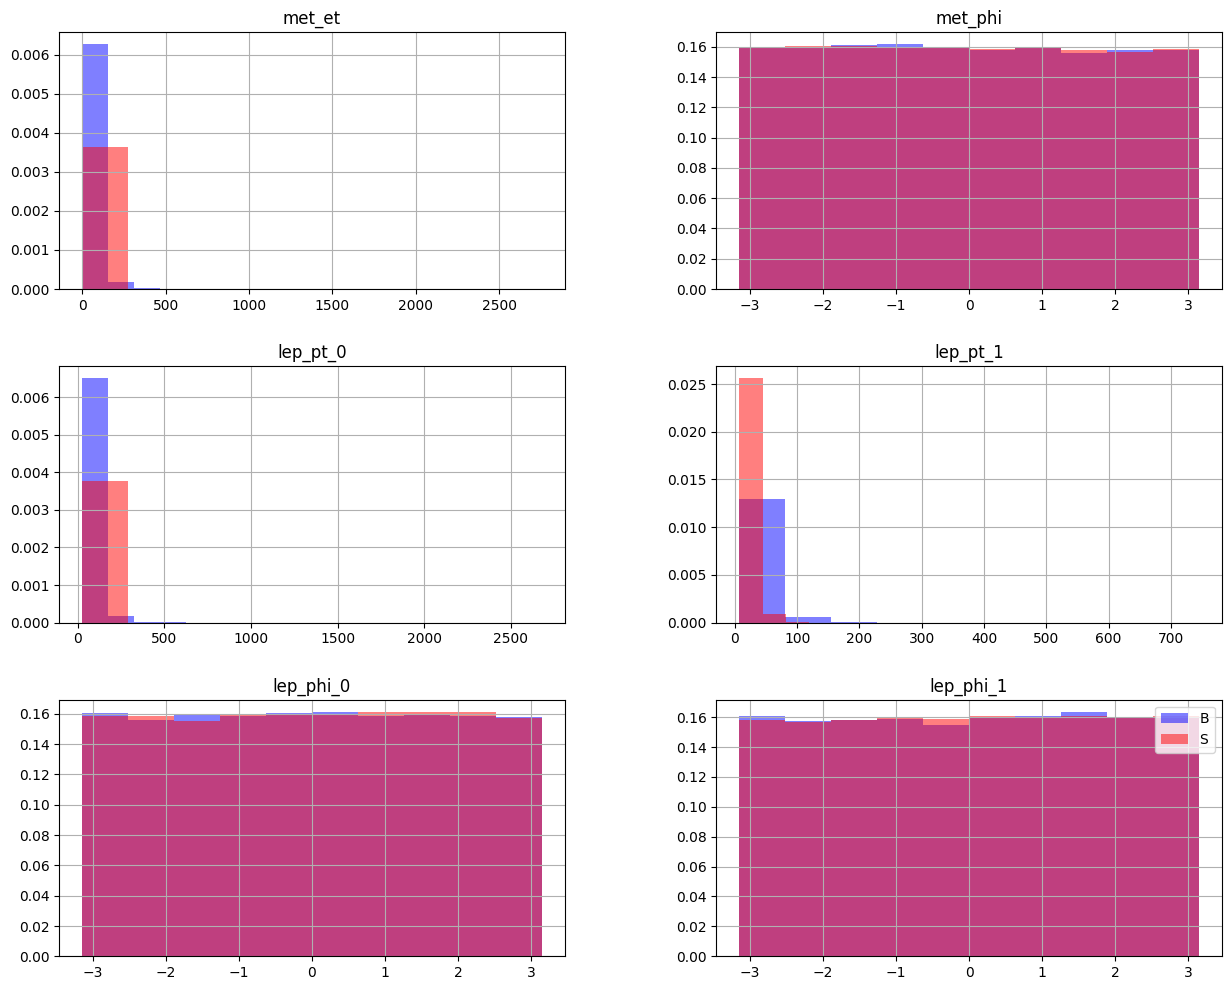

In [19]:
plt.figure()

ax = data[target == 0].hist(weights=weights[target == 0], figsize=(15, 12), color='b', alpha=0.5, density=True, label="B")
ax = ax.flatten()[: data.shape[1]]  # to avoid error if holes in the grid of plots (like if 7 or 8 features)
ax = data[target == 1].hist(
    weights=weights[target == 1], figsize=(15, 12), color='r', alpha=0.5, density=True, ax=ax, label="S"
)
# ax.legend(loc="best")

plt.legend(loc="best")
plt.show()

### Features correlation matrix

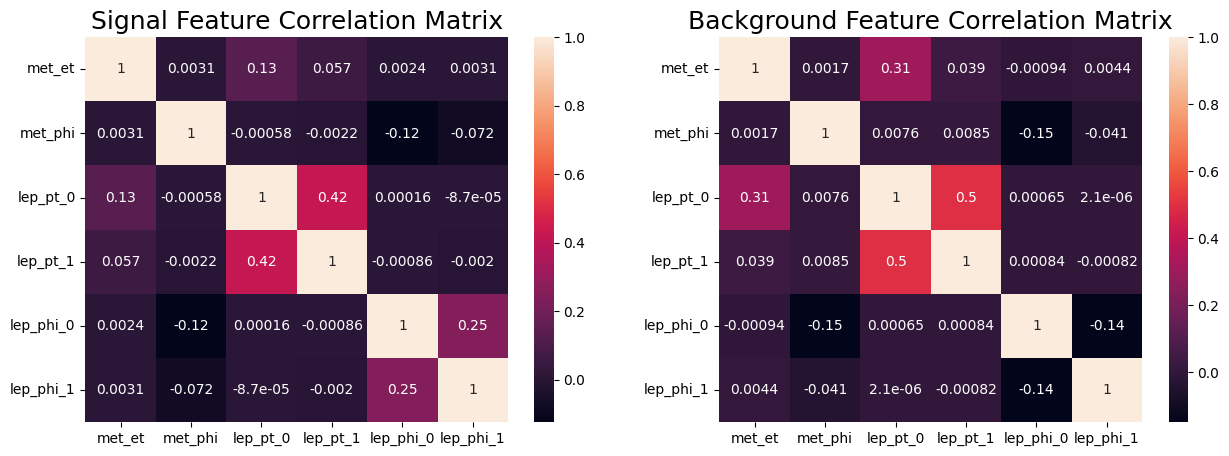

In [21]:
import seaborn as sn  # seaborn for plots with more appealing defaults

fig, axes = plt.subplots(1, 2, sharex=True, figsize=(15, 5))
corrMatrix = data[target == 1].corr()
sn.heatmap(corrMatrix, annot=True, ax=axes[0])
axes[0].set_title("Signal Feature Correlation Matrix", fontsize=18)

# print ("Background feature correlation matrix")
corrMatrix = data[target == 0].corr()
sn.heatmap(corrMatrix, annot=True, ax=axes[1])
_ = axes[1].set_title("Background Feature Correlation Matrix", fontsize=18)

# Preprocess Data

## Split Data into Test and Training

In [22]:
np.random.seed(31415)

from sklearn.model_selection import train_test_split

train_size = 0.75  # fraction of sample used for training

X_train, X_test, y_train, y_test, weights_train, weights_test = train_test_split(
    data, target, weights, train_size=train_size
)

# Reset index for dataseries, not needed for ndarray (X_train, X_test)
# Basically just re-adding the original element indexing from pandas
y_train, y_test, weights_train, weights_test = (
    y_train.reset_index(drop=True),
    y_test.reset_index(drop=True),
    weights_train.reset_index(drop=True),
    weights_test.reset_index(drop=True),
)

print("X_train shape:", X_train.shape)
print("y_train shape:", y_train.shape)
print("weights shape:", weights_train.shape, "\n")

print("X_test shape:", X_test.shape)
print("y_test shape:", y_test.shape)
print("weight shape:", weights_test.shape, "\n")

X_train shape: (433017, 6)
y_train shape: (433017,)
weights shape: (433017,) 

X_test shape: (144340, 6)
y_test shape: (144340,)
weight shape: (144340,) 



## Standardize the Data

**Scale to Mean of 0 and Variance of 1.0:**   $\ \ \ \ (x-\mu)/\sigma$

In [23]:
# not usually needed for BDT but is good practice
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)  # applies the transformation calculated the line above

## Adjust the Test and Train Signal/Background Weights
Train on equal amount of Signal and Background, Test on 'natural' ratio

In [24]:
class_weights_train = (weights_train[y_train == 0].sum(), weights_train[y_train == 1].sum())

for i in range(len(class_weights_train)):  # loop on B then S targets(labels)
    # training dataset: equalize number of background and signal
    weights_train[y_train == i] *= max(class_weights_train) / class_weights_train[i]

    # test dataset : increase test weight to compensate for sampling
    weights_test[y_test == i] *= 1 / (1 - train_size)

print("Weights have been normalised to a given number of proton collision")
print("Orig : total weight sig", weights[target == 1].sum())
print("Orig : total weight bkg", weights[target == 0].sum(), "\n")

print("Test : total weight sig", weights_test[y_test == 1].sum())
print("Test : total weight bkg", weights_test[y_test == 0].sum(), "\n")
print("Train : total weight sig", weights_train[y_train == 1].sum())
print("Train : total weight bkg", weights_train[y_train == 0].sum())

Weights have been normalised to a given number of proton collision
Orig : total weight sig 24.717592998400008
Orig : total weight bkg 638.7539675983998 

Test : total weight sig 24.717773318400006
Test : total weight bkg 635.6988284976001 

Train : total weight sig 479.8292604740002
Train : total weight bkg 479.82926047399997


# Train with LightGBM (handles negative weighted events unlike XGBoost)

In [27]:
np.random.seed(31415)  # set the random seed

import lightgbm as lgb
from sklearn.metrics import roc_auc_score  # for binary classification if x > 0.5 -> 1 else -> 0

# gbm = lgb.LGBMClassifier()
gbm = lgb.LGBMClassifier() # HPO, check on the web https://lightgbm.readthedocs.io/ for other parameters


starting_time = time.time()

gbm.fit(X_train, y_train.values, sample_weight=weights_train.values)


training_time = time.time() - starting_time
print("Training time:", training_time)

y_pred_gbm = gbm.predict_proba(X_test)[:, 1]
y_pred_gbm = y_pred_gbm.ravel()
y_pred_train_gbm = gbm.predict_proba(X_train)[:, 1].ravel()
auc_test_gbm = roc_auc_score(y_true=y_test, y_score=y_pred_gbm, sample_weight=weights_test)
print("auc test:", auc_test_gbm)
print("auc train:", roc_auc_score(y_true=y_train.values, y_score=y_pred_train_gbm, sample_weight=weights_train))
print("auc test without weights", roc_auc_score(y_true=y_test, y_score=y_pred_gbm))

Training time: 1.1852221488952637
auc test: 0.8296102251691393
auc train: 0.8379442181132511
auc test without weights 0.8240523219532092


## Significance Function

$\mathrm{med}[Z_0|1] = \sqrt{q_{0,A}} = \sqrt{2+((s+b)\ln(1+s/b)-s)}$

**asimov significance [arXiv:1007.1727](https://arxiv.org/pdf/1007.1727.pdf) [Eq. 97]**

asimov for significance. Need to esimate your sensitivity to MC. Need thousands of toy tests everytime you use simulation, you need to test your sensitivity. Running a toy MC thousands of times, should converge to 'truth'. Asimov is representative of. Number of sigmas.

In [29]:
from math import sqrt
from math import log


def amsasimov(s, b):
    if b <= 0 or s <= 0:
        return 0
    try:
        return sqrt(2 * ((s + b) * log(1 + float(s) / b) - s))
    except ValueError:
        print(1 + float(s) / b)
        print(2 * ((s + b) * log(1 + float(s) / b) - s))
    # return s/sqrt(s+b)

In [30]:
# sum S & B after certain thresholds
int_pred_test_sig_gbm = [weights_test[(y_test == 1) & (y_pred_gbm > th_cut)].sum() for th_cut in np.linspace(0, 1, num=50)]
int_pred_test_bkg_gbm = [weights_test[(y_test == 0) & (y_pred_gbm > th_cut)].sum() for th_cut in np.linspace(0, 1, num=50)]

vamsasimov_gbm = [amsasimov(sumsig, sumbkg) for (sumsig, sumbkg) in zip(int_pred_test_sig_gbm, int_pred_test_bkg_gbm)]
significance_gbm = max(vamsasimov_gbm)
Z = significance_gbm
print("Z:", Z)

Z: 1.4217297300407892


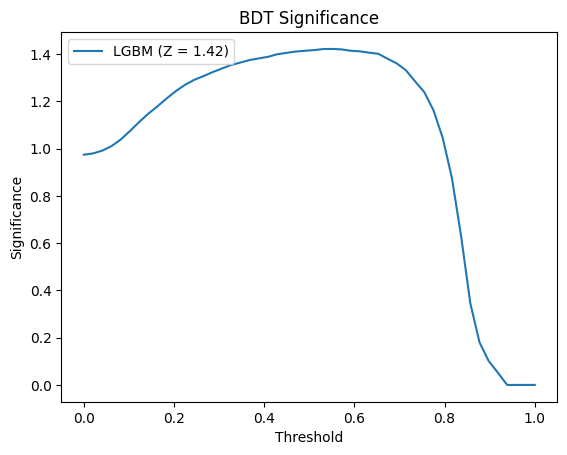

In [32]:
plt.plot(np.linspace(0, 1, num=50), vamsasimov_gbm, label='LGBM (Z = {})'.format(np.round(significance_gbm, decimals=2)))


plt.title("BDT Significance")
plt.xlabel("Threshold")
plt.ylabel("Significance")
plt.legend()
plt.savefig("Significance_gbm.pdf")
plt.show()

In [33]:
from extra_functions import compare_train_test

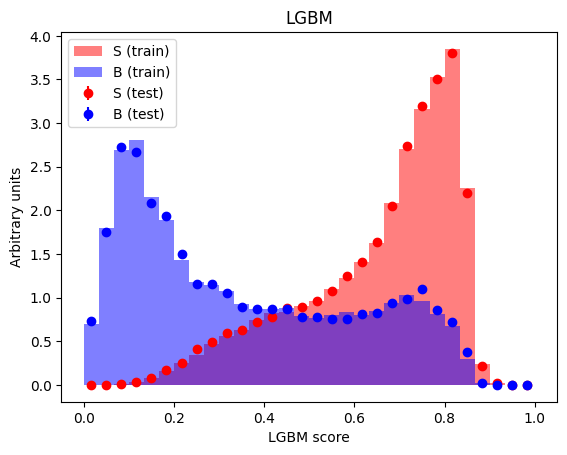

In [35]:
compare_train_test(
    y_pred_train_gbm,
    y_train,
    y_pred_gbm,
    y_test,
    xlabel="LGBM score",
    title="LGBM",
    weights_train=weights_train.values,
    weights_test=weights_test.values,
)

plt.savefig("Score_BDT_GBM_Hist.pdf")

# Hyper Parameter Optimisation
**Come back to this if done early**

- Can be done by hand or with [random search](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.RandomizedSearchCV.html) or [grid search](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html) .

In [ ]:
# This takes a while. Feel free to come back here after finishing
do_HP_optimization = False

In [ ]:
# RandomSearchCV for advanced HPO
import scipy.stats as stats

if do_HP_optimization:
    from sklearn.model_selection import RandomizedSearchCV

    # specify parameters, range, and distributions to sample from
    param_dist_XGB = {
        'max_depth': stats.randint(3, 12),  # default 6
        'n_estimators': stats.randint(300, 800),  # default 100
        'learning_rate': stats.uniform(0.1, 0.5),
    }  # def 0.3

    # default CV is 5 fold, reduce to 2 for speed concern
    gsearch = RandomizedSearchCV(
        estimator=XGBClassifier(tree_method="hist", use_label_encoder=False, eval_metric='logloss'),
        param_distributions=param_dist_XGB,
        scoring='roc_auc',
        n_iter=10,
        cv=2,
    )
    gsearch.fit(X_train, y_train, sample_weight=weights_train)

    print("Best parameters : ", gsearch.best_params_)
    print("Best score (on train dataset CV) : ", gsearch.best_score_)

    y_pred_gs = gsearch.predict_proba(X_test)[:, 1]
    print(
        "... corresponding score on test dataset : ",
        roc_auc_score(y_true=y_test, y_score=y_pred_gs, sample_weight=weights_test),
    )
    dfsearch = pd.DataFrame.from_dict(gsearch.cv_results_)
    display(dfsearch)

In [ ]:
if do_HP_optimization:
    dfsearch.plot.scatter("param_n_estimators", "mean_test_score")
    dfsearch.plot.scatter("param_max_depth", "mean_test_score")
    dfsearch.plot.scatter("param_learning_rate", "mean_test_score")

# Learning Curve
This could be done with sklearn  [learning_curve](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.learning_curve.html).
However, older versions cannot handle weights, and therefore do not allow you to control testing dataset size. Need to check newer versions



In [37]:
from sklearn.metrics import roc_curve

Do_Learning_Curve = True

In [47]:
if Do_Learning_Curve:
    #train_sizes = [0.01, 0.05, 0.1, 0.2, 0.5, 0.75, 1]
    train_sizes = [0.001, 0.003, 0.005, 0.01, 0.05, 0.1, 0.2]
    ntrains = []
    test_aucs = []
    train_aucs = []
    times = []
    fpr = []
    tpr = []

    for train_size in train_sizes:
        ntrain = int(len(X_train) * train_size)
        print("training with ", ntrain, " events")
        ntrains += [ntrain]
        starting_time = time.time()

        # train using the first ntrain event of the training dataset
        gbm.fit(X_train[:ntrain,], y_train[:ntrain], sample_weight=weights_train[:ntrain])
        training_time = time.time() - starting_time
        times += [training_time]

        # score on test dataset (always the same)
        y_pred_gbm = gbm.predict_proba(X_test)[:, 1]
        auc_test_gbm = roc_auc_score(y_true=y_test, y_score=y_pred_gbm, sample_weight=weights_test)
        test_aucs += [auc_test_gbm]

        # score on the train dataset
        y_train_gbm = gbm.predict_proba(X_train[:ntrain])[:, 1]
        auc_train_gbm = roc_auc_score(y_true=y_train[:ntrain], y_score=y_train_gbm, sample_weight=weights_train[:ntrain])
        train_aucs += [auc_train_gbm]
        dflearning = pd.DataFrame({"Ntraining": ntrains, "test_auc": test_aucs, "train_auc": train_aucs, "time": times})

        #temp_fpr, temp_tpr, _ = roc_curve(y_true=y_train[:ntrain], y_score=y_train_gbm, sample_weight=weights_train[:ntrain])
        temp_fpr, temp_tpr, _ = roc_curve(y_true=y_test, y_score=y_pred_gbm, sample_weight=weights_test)
        fpr += [temp_fpr]
        tpr += [temp_tpr]

    display(dflearning)

training with  433  events
training with  1299  events
training with  2165  events
training with  4330  events
training with  21650  events
training with  43301  events
training with  86603  events


,Ntraining,test_auc,train_auc,time
0,433,0.760982,0.999749,0.245127
1,1299,0.781155,0.999226,0.444594
2,2165,0.797770,0.998012,0.424984
3,4330,0.817944,0.991254,0.421769
4,21650,0.843369,0.932302,0.486911
5,43301,0.840228,0.898299,0.552760
6,86603,0.840237,0.873510,0.705435


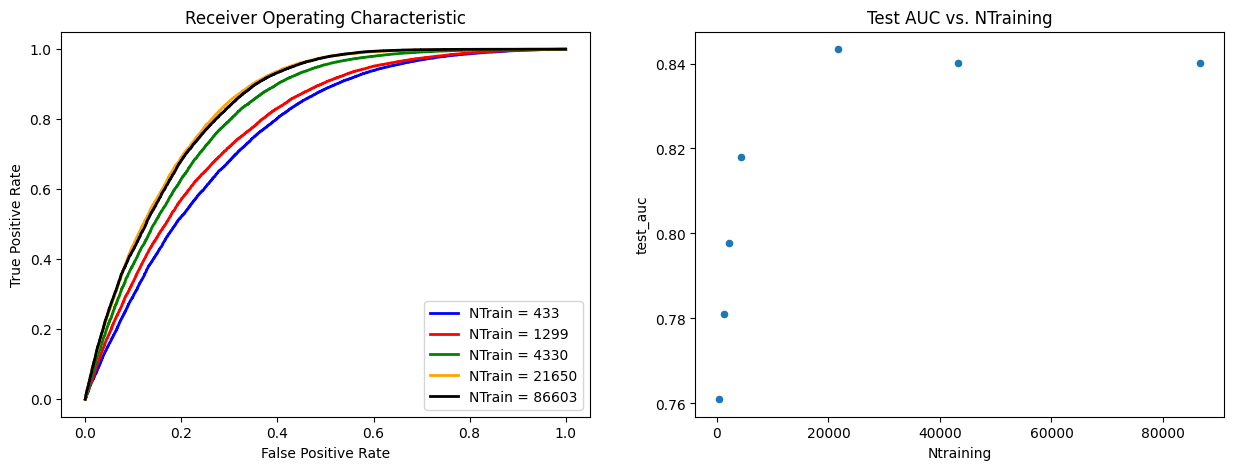

In [50]:
if Do_Learning_Curve:
    fig, axes = plt.subplots(1, 2, figsize=(15, 5))
    lw = 2
    # axes[0].plot(fpr_xgb, tpr_xgb, color='blue',lw=lw, label='XGBoost (AUC  = {})'.format(np.round(auc_test_xgb,decimals=2)))
    axes[0].plot(fpr[0], tpr[0], color='blue', lw=lw, label='NTrain = %i' % (ntrains[0]))
    axes[0].plot(fpr[1], tpr[1], color='red', lw=lw, label='NTrain = %i' % (ntrains[1]))
    axes[0].plot(fpr[3], tpr[3], color='green', lw=lw, label='NTrain = %i' % (ntrains[3]))
    axes[0].plot(fpr[4], tpr[4], color='orange', lw=lw, label='NTrain = %i' % (ntrains[4]))
    axes[0].plot(fpr[6], tpr[6], color='black', lw=lw, label='NTrain = %i' % (ntrains[6]))

    axes[0].legend()
    axes[0].set_xlabel('False Positive Rate')
    axes[0].set_ylabel('True Positive Rate')
    axes[0].set_title('Receiver Operating Characteristic')

    axes[1].set_title("Test AUC vs. NTraining")
    dflearning.plot.scatter("Ntraining", "test_auc", ax=axes[1])
    # focus on the last point
    # dflearning[4:].plot.scatter("Ntraining","test_auc")

# Feature importance
Feature importance allows to display the importance of each feature without rerunnning the training. 

It is obtained from internal algorithm quantities, like number of time a feature is used to define leaf, and the information gained from the nodes that use that feature.

Magnitude is arbitrary. It not always a reliable indication of which feature is the most discriminant.

In [57]:
gbm._Booster.dump_model()['feature_names']

['Column_0', 'Column_1', 'Column_2', 'Column_3', 'Column_4', 'Column_5']

<Axes: title={'center': 'Feature importance'}, xlabel='Feature importance', ylabel='Features'>

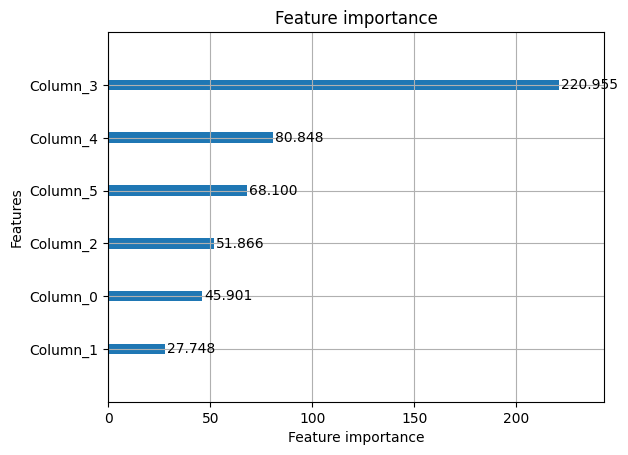

In [55]:
#plt.bar(data.columns.values, xgb.feature_importances_)
lightgbm.plot_importance(booster=gbm, 
                         importance_type='gain',
                        title= "Feature importance (gain)",
                        )
#plt.xticks(rotation=90)
#plt.title("Feature importances Light GBM")

# Permutation importance

A better way to show the importance of each feature is Permutation Importance, where each feature in turn is replaced by an instance of that feature from another event (effectively switching it off by randomising).
In particular it allows one to : 
   * display directly the loss in whatever criteria (ROC auc, asimov significance) when the feature is switched off
   * display the feature importance for a specific subset (for example the most signal like)
   * it can even display which feature has the larges impact on systematics


However, report can be misleading in case of highly correlated variables. 
   


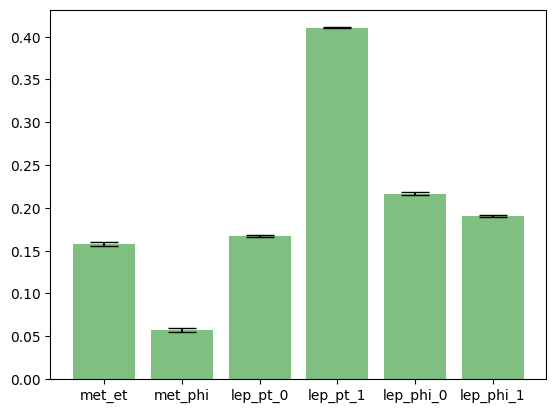

In [67]:
from permutationimportancephysics.PermutationImportance import PermulationImportance
pi = PermulationImportance(model=gbm, X=X_test,y=y_test,weights=weights_test,n_iterations=3,usePredict_poba=True,
                      scoreFunction="amsasimov", colNames=data.columns)
plt = pi.plotBars()
plt.show()

### Score Plot without Renormalizing

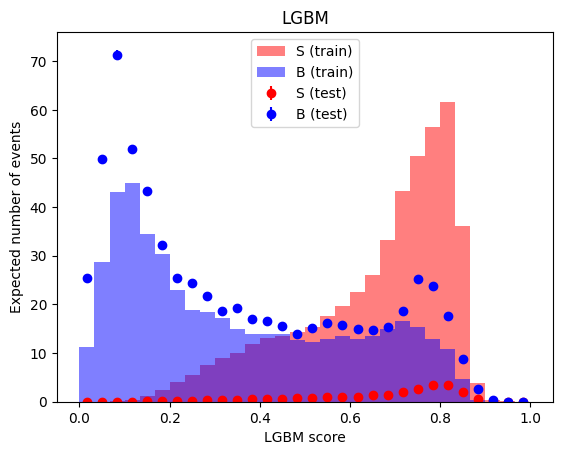

In [68]:
compare_train_test(
    y_pred_train_gbm,
    y_train,
    y_pred_gbm,
    y_test,
    xlabel="LGBM score",
    ylabel="Expected number of events",
    title="LGBM",
    weights_train=weights_train.values,
    weights_test=weights_test.values,
    density=False,
)

# Extra BDT Examples

___
__Example with sklearn (but without weights and with no fixed test dataset):__

In [ ]:
# change this cell from 'raw' to 'code'
from sklearn.model_selection import learning_curve

train_sizes, train_scores, test_scores = learning_curve(
    XGBClassifier(tree_method="hist", use_label_encoder=False, eval_metric='logloss', n_estimators=10),
    X_train,
    y_train,
    train_sizes=[0.01, 0.05, 0.1, 0.2, 0.5, 0.75, 1],
    scoring='roc_auc',
    cv=5,
)

___

# Train BDT using [XGBoost](https://arxiv.org/abs/1603.02754)

In [ ]:
np.random.seed(31415)  # set the random seed

from xgboost import XGBClassifier
from sklearn.metrics import roc_auc_score  # for binary classification if x > 0.5 -> 1 else -> 0

xgb = XGBClassifier(tree_method="hist", use_label_encoder=False, eval_metric='logloss')
# tree_method="hist" is 10 times faster, however less robust against awkwards features (not a bad idea to double check without it)
# can even try tree_method="gpu_hist" if proper GPU installation
# use_label_encoder and eval_metric to silence warning in 1.3.0

# HPO (==Hyper Parameter Optimization), check on the web https://xgboost.readthedocs.io/ for other parameters
# xgb = XGBClassifier(tree_method="hist",use_label_encoder=False,max_depth=10,n_estimators=100)


starting_time = time.time()

xgb.fit(X_train, y_train.values, sample_weight=weights_train.values)  # note that XGB 1.3.X requires positive weight

training_time = time.time() - starting_time
print("Training time:", training_time)

y_pred_xgb = xgb.predict_proba(X_test)[:, 1]
y_pred_xgb = y_pred_xgb.ravel()
y_pred_train_xgb = xgb.predict_proba(X_train)[:, 1].ravel()
auc_test_xgb = roc_auc_score(y_true=y_test, y_score=y_pred_xgb, sample_weight=weights_test)
print("auc test:", auc_test_xgb)
print("auc train:", roc_auc_score(y_true=y_train.values, y_score=y_pred_train_xgb, sample_weight=weights_train), "\n")

print("auc test without weights", roc_auc_score(y_true=y_test, y_score=y_pred_xgb))

In [ ]:
# sum S & B after certain thresholds
int_pred_test_sig_xgb = [weights_test[(y_test == 1) & (y_pred_xgb > th_cut)].sum() for th_cut in np.linspace(0, 1, num=50)]
int_pred_test_bkg_xgb = [weights_test[(y_test == 0) & (y_pred_xgb > th_cut)].sum() for th_cut in np.linspace(0, 1, num=50)]

vamsasimov_xgb = [amsasimov(sumsig, sumbkg) for (sumsig, sumbkg) in zip(int_pred_test_sig_xgb, int_pred_test_bkg_xgb)]
significance_xgb = max(vamsasimov_xgb)  # finds the maximum significance. Which threshold results in this significance?
Z = significance_xgb
print("Z:", Z)

## SKLearn GBDT

In [ ]:
from sklearn import ensemble

# possible parameters, just take the default
# original_params = {
#    "n_estimators": 400,
#    "max_leaf_nodes": 4,
#    "max_depth": None,
#    "random_state": 2,
#    "min_samples_split": 5,
# }

skgb = ensemble.HistGradientBoostingClassifier()


starting_time = time.time()

skgb.fit(X_train, y_train.values, sample_weight=weights_train.values)


training_time = time.time() - starting_time
print("Training time:", training_time)

y_pred_skgb = skgb.predict_proba(X_test)[:, 1]
y_pred_skgb = y_pred_skgb.ravel()
y_pred_train_skgb = skgb.predict_proba(X_train)[:, 1].ravel()
auc_test_skgb = roc_auc_score(y_true=y_test, y_score=y_pred_skgb, sample_weight=weights_test)
print("auc test:", auc_test_skgb)
print("auc train:", roc_auc_score(y_true=y_train.values, y_score=y_pred_train_skgb, sample_weight=weights_train))

int_pred_test_sig_skgb = [weights_test[(y_test == 1) & (y_pred_skgb > th_cut)].sum() for th_cut in np.linspace(0, 1, num=50)]
int_pred_test_bkg_skgb = [weights_test[(y_test == 0) & (y_pred_skgb > th_cut)].sum() for th_cut in np.linspace(0, 1, num=50)]

vamsasimov_skgb = [amsasimov(sumsig, sumbkg) for (sumsig, sumbkg) in zip(int_pred_test_sig_skgb, int_pred_test_bkg_skgb)]
significance_skgb = max(vamsasimov_skgb)
Z = significance_skgb
print("Z:", Z)

In [ ]:
print('Best significance found are:')
print('XGBoost : ', significance_xgb)
print('LightGBM: ', significance_gbm)
print('sklearn: ', significance_skgb)


print('Best auc test found are:')
print('XGBoost: ', roc_auc_score(y_true=y_test.values, y_score=y_pred_xgb, sample_weight=weights_test))
print('LightGBM: ', roc_auc_score(y_true=y_test.values, y_score=y_pred_gbm, sample_weight=weights_test))
print('sklearn: ', roc_auc_score(y_true=y_test.values, y_score=y_pred_skgb, sample_weight=weights_test))

## Some nice plots 

### load score plotting function

In [ ]:
# Plot score for signal and background, comparing training and testing
def compare_train_test(
    y_pred_train,
    y_train,
    y_pred,
    y_test,
    high_low=(0, 1),
    bins=30,
    xlabel="",
    ylabel="Arbitrary units",
    title="",
    weights_train=np.array([]),
    weights_test=np.array([]),
    density=True,
):
    if weights_train.size != 0:
        weights_train_signal = weights_train[y_train == 1]
        weights_train_background = weights_train[y_train == 0]
    else:
        weights_train_signal = None
        weights_train_background = None
    plt.hist(
        y_pred_train[y_train == 1],
        color='r',
        alpha=0.5,
        range=high_low,
        bins=bins,
        histtype='stepfilled',
        density=density,
        label='S (train)',
        weights=weights_train_signal,
    )  # alpha is transparancy
    plt.hist(
        y_pred_train[y_train == 0],
        color='b',
        alpha=0.5,
        range=high_low,
        bins=bins,
        histtype='stepfilled',
        density=density,
        label='B (train)',
        weights=weights_train_background,
    )

    if weights_test.size != 0:
        weights_test_signal = weights_test[y_test == 1]
        weights_test_background = weights_test[y_test == 0]
    else:
        weights_test_signal = None
        weights_test_background = None
    hist, bins = np.histogram(y_pred[y_test == 1], bins=bins, range=high_low, density=density, weights=weights_test_signal)
    scale = len(y_pred[y_test == 1]) / sum(hist)
    err = np.sqrt(hist * scale) / scale

    center = (bins[:-1] + bins[1:]) / 2
    plt.errorbar(center, hist, yerr=err, fmt='o', c='r', label='S (test)')

    hist, bins = np.histogram(
        y_pred[y_test == 0], bins=bins, range=high_low, density=density, weights=weights_test_background
    )
    scale = len(y_pred[y_test == 0]) / sum(hist)
    err = np.sqrt(hist * scale) / scale

    center = (bins[:-1] + bins[1:]) / 2
    plt.errorbar(center, hist, yerr=err, fmt='o', c='b', label='B (test)')
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.legend(loc='best')

In [ ]:
compare_train_test(
    y_pred_train_xgb,
    y_train,
    y_pred_xgb,
    y_test,
    xlabel="XGboost score",
    title="XGboost",
    weights_train=weights_train.values,
    weights_test=weights_test.values,
)
plt.savefig("Score_BDT_XGBoost_Hist.pdf")
plt.show()
compare_train_test(
    y_pred_train_gbm,
    y_train,
    y_pred_gbm,
    y_test,
    xlabel="LightGBM score",
    title="LightGBM",
    weights_train=weights_train.values,
    weights_test=weights_test.values,
)
plt.savefig("Score_BDT_LightGBM.pdf")
plt.show()
compare_train_test(
    y_pred_train_skgb,
    y_train,
    y_pred_skgb,
    y_test,
    xlabel="sklearn score",
    title="sklearn",
    weights_train=weights_train.values,
    weights_test=weights_test.values,
)
plt.savefig("Score_BDT_sklearn.pdf")
plt.show()

### Plot without renormalising

In [ ]:
compare_train_test(
    y_pred_train_xgb,
    y_train,
    y_pred_xgb,
    y_test,
    xlabel="XGboost score",
    ylabel="Expected number of events",
    title="XGboost",
    weights_train=weights_train.values,
    weights_test=weights_test.values,
    density=False,
)
plt.savefig("Score_BDT_XGBoost_Hist.pdf")
plt.show()

### ROC curve

In [ ]:
from sklearn.metrics import roc_curve

lw = 2

fpr_xgb, tpr_xgb, _ = roc_curve(y_true=y_test, y_score=y_pred_xgb, sample_weight=weights_test.values)
fpr_gbm, tpr_gbm, _ = roc_curve(y_true=y_test, y_score=y_pred_gbm, sample_weight=weights_test.values)
fpr_skgb, tpr_skgb, _ = roc_curve(y_true=y_test, y_score=y_pred_skgb, sample_weight=weights_test.values)


plt.plot(fpr_xgb, tpr_xgb, color='darkgreen', lw=lw, label='XGBoost (AUC  = {})'.format(np.round(auc_test_xgb, decimals=2)))
plt.plot(
    fpr_skgb, tpr_skgb, color='darkblue', lw=lw, label='sklearn (AUC  = {})'.format(np.round(auc_test_skgb, decimals=2))
)
plt.plot(
    fpr_gbm, tpr_gbm, color='darkorange', lw=lw, label='LightGBM (AUC  = {})'.format(np.round(auc_test_gbm, decimals=2))
)


plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
# import os
# new_dir = "Plots/Comparing"
# if not os.path.isdir(new_dir):
#    os.mkdir(new_dir)
plt.savefig("ROC_comparing.pdf")
plt.show()  # blue line = random classification -> maximize true positive rate while miniize false positive rate

### Significance curve

In [ ]:
plt.plot(np.linspace(0, 1, num=50), vamsasimov_xgb, label='XGBoost (Z = {})'.format(np.round(significance_xgb, decimals=2)))
plt.plot(
    np.linspace(0, 1, num=50), vamsasimov_skgb, label='sklearn (Z = {})'.format(np.round(significance_skgb, decimals=2))
)
plt.plot(np.linspace(0, 1, num=50), vamsasimov_gbm, label='LightGBM (Z = {})'.format(np.round(significance_gbm, decimals=2)))


plt.title("BDT Significance")
plt.xlabel("Threshold")
plt.ylabel("Significance")
plt.legend()
plt.savefig("Significance_comparing.pdf")
plt.show()

## XGBoost and LightGBM Feature Importance
Feature importance allows to display the importance of each feature without rerunnning the training. It is obtained from internal algorithm quantities, like number of time a feature is used to define leaf, and the information gained from the nodes that use that feature. Magnitude is arbitrary. It not always a reliable indication of which feature is the most discriminant.

In [ ]:
plt.bar(data.columns.values, xgb.feature_importances_)
plt.xticks(rotation=90)
plt.title("Feature importances XGBoost Hist")
# plt.savefig(new_dir + "/VarImp_BDT_XGBoost_Hist.pdf",bbox_inches='tight')
plt.show()
plt.bar(data.columns.values, gbm.feature_importances_) # not gain
plt.xticks(rotation=90)
plt.title("Feature importances LightGBM")
# plt.savefig(new_dir + "/VarImp_BDT_LightGBM.pdf",bbox_inches='tight')
plt.show()

##  Model serialisation
It is useful to be able to save a model in order to apply it without retraining. There are many ways to do it. One is to save the whole python object with joblib (beware this is not safe if the software evolves). Another is to used dedicated serialisation like the one proposed by xgboost.


In [ ]:
#WARNING : StandardScaler has not been saved
# one can look into sklearn pipeline
if False:
    import joblib
    myxgb = XGBClassifier(tree_method="hist",use_label_encoder=False,eval_metric='logloss',n_estimators=5)
    myxgb.fit(X_train, y_train, sample_weight=weights_train)

    auc_test_xgb = roc_auc_score(y_true=y_test, y_score=myxgb.predict_proba(X_test)[:,1],sample_weight=weights_test)
 
    # save model
    myxgb.save_model("XGBoost.json")


    # save python object
    joblib.dump(myxgb, "myxgb.dat")

    print ("myxgb score",auc_test_xgb)

    del myxgb # delete xgb object

    # reload model
    myxgb_reloaded_from_model =XGBClassifier()
    myxgb_reloaded_from_model.load_model("XGBoost.json")
    print ("myxgb reloaded from model",
           roc_auc_score(y_true=y_test, 
                         y_score=myxgb_reloaded_from_model.predict_proba(X_test)[:,1],sample_weight=weights_test)
          )


    # reload object
    myxgb_reloaded_from_joblib=joblib.load("myxgb.dat")
    print ("myxgb reloaded from object",
           roc_auc_score(y_true=y_test, 
                         y_score=myxgb_reloaded_from_joblib.predict_proba(X_test)[:,1],sample_weight=weights_test)
          )
    # dump json file
    !python -m json.tool XGBoost.json





